In [1]:
import minari
import pickle
import numpy as np
import collections
import minari


def _load_dataset_minari(env_name, dataset = None): # jensk

    trajectories = dataset
    states, traj_lens, returns = [], [], []
    if 'pointmaze' in env_name :
        # re-label observation. (achieved_goal, desired_goal) -> observation
        print("re-label observation. (achieved_goal, desired_goal) -> observation")
        for path in trajectories :
            achieved_goal = path['observations']['achieved_goal'][1:]
            desired_goal = path['observations']['desired_goal'][1:]
            observation = np.concatenate([achieved_goal, desired_goal], axis=1)
            path['observations'] = observation

    for path in trajectories:
        states.append(path["observations"])
        traj_lens.append(len(path["observations"]))
        returns.append(path["rewards"].sum())
        # for pointmaze
    traj_lens, returns = np.array(traj_lens), np.array(returns)
    states = np.concatenate(states, axis=0)
    state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
    num_timesteps = sum(traj_lens)

    print("=" * 50)
    print(f"Starting new experiment: {env_name}")
    print(f"{len(traj_lens)} trajectories, {num_timesteps} timesteps found")
    print(f"Average return: {np.mean(returns):.2f}, std: {np.std(returns):.2f}")
    print(f"Max return: {np.max(returns):.2f}, min: {np.min(returns):.2f}")
    print(f"Average length: {np.mean(traj_lens):.2f}, std: {np.std(traj_lens):.2f}")
    print(f"Max length: {np.max(traj_lens):.2f}, min: {np.min(traj_lens):.2f}")
    print("=" * 50)

    sorted_inds = np.argsort(returns)  # lowest to highest
    num_trajectories = 1
    timesteps = traj_lens[sorted_inds[-1]]
    ind = len(trajectories) - 2
    while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] < num_timesteps:
        timesteps += traj_lens[sorted_inds[ind]]
        num_trajectories += 1
        ind -= 1
    sorted_inds = sorted_inds[-num_trajectories:]

    trajectories = [trajectories[ii] for ii in sorted_inds]
    return trajectories, state_mean, state_std

def _load_dataset_01(env_name) :

    offline_trajs, state_mean, state_std = _load_dataset_minari(env_name, dataset)
    # create ['K'] length trajectories with initial state and final state
    offline_trajs_01 = []
    for traj in offline_trajs:
        traj_len = len(traj["observations"])
        # divide the trajectory into K length. get index of K length
        if traj_len < variant["K"] :
            continue 
        index = np.linspace(0, traj_len - 1, variant["K"]).astype(int)
        #print(f"traj len: {traj_len}, index : {index}")
        # get the state and action of the index
        # get the initial action and final action
        for key in traj.keys() :
            if key in ['id', 'total_timesteps', 'seed' ] :
                continue
            traj[key] = traj[key][index]
        offline_trajs_01.append(traj)
    for traj in offline_trajs_01[:10] :
        print(traj['rewards'].any())
    
    print(f"offline_trajs_01 : {len(offline_trajs_01)}")
    return offline_trajs_01, state_mean, state_std
    
    


/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

env_name = "pointmaze-umaze-v1"
actual_env_name = 'PointMaze_Umaze-v3'
dataset = minari.load_dataset("pointmaze-umaze-v1")
dataset = dataset._data.get_episodes(range(0,1000))

variant = {}
variant['K'] = 20

data, state_mean, state_std = _load_dataset_01('pointmaze-umaze-v1')

re-label observation. (achieved_goal, desired_goal) -> observation
Starting new experiment: pointmaze-umaze-v1
1000 trajectories, 73537 timesteps found
Average return: 1.00, std: 0.00
Max return: 1.00, min: 1.00
Average length: 73.54, std: 43.50
Max length: 183.00, min: 1.00
True
True
True
True
True
True
True
True
True
True
offline_trajs_01 : 885


In [3]:
from decision_transformer.models.decision_transformer import DecisionTransformer01
import torch
from pathlib import Path
import random
import numpy as np
MAX_EPISODE_LEN = 1000

variant = {
    "seed": 10,
    "env": "PointMaze_Umaze-v3",
    "K": 5,
    "embed_dim": 512,
    "n_layer": 4,
    "n_head": 4,
    "activation_function": "relu",
    "dropout": 0.1,
    "eval_context_length": 5,
    "ordering": 0,
    "eval_rtg": 3600,
    "num_eval_episodes": 10,
    "init_temperature": 0.1,
    "batch_size": 256,
    "learning_rate": 1e-4,
    "weight_decay": 5e-4,
    "warmup_steps": 10000,
    "max_pretrain_iters": 1,
    "num_updates_per_pretrain_iter": 5000,
    "max_online_iters": 1500,
    "online_rtg": 7200,
    "num_online_rollouts": 1,
    "replay_size": 1000,
    "num_updates_per_online_iter": 300,
    "eval_interval": 10,
    "device": "cuda",
    "log_to_tb": True,
    "save_dir": "./exp",
    "exp_name": "default",
    "tags": "model:01"
}

device = 'cuda'

model = DecisionTransformer01(
    state_dim= 4,
    state_range= [-5,5],
    max_length=variant["K"],
    eval_context_length=variant["eval_context_length"],
    max_ep_len=MAX_EPISODE_LEN,
    hidden_size=variant["embed_dim"],
    n_layer=variant["n_layer"],
    n_head=variant["n_head"],
    n_inner=4 * variant["embed_dim"],
    activation_function=variant["activation_function"],
    n_positions=1024,
    resid_pdrop=variant["dropout"],
    attn_pdrop=variant["dropout"],
    stochastic_policy=True,
    ordering=variant["ordering"],
    init_temperature=variant["init_temperature"],
    target_entropy= -4,
).to(device=device)


path_prefix = "./exp/2023.12.26/083526-default"
if Path(f"{path_prefix}/model.pt").exists():
    with open(f"{path_prefix}/model.pt", "rb") as f:
        checkpoint = torch.load(f)
    model.load_state_dict(checkpoint["model_state_dict"])
    #self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    #self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    #self.log_temperature_optimizer.load_state_dict(
    #    checkpoint["log_temperature_optimizer_state_dict"]
    #)
    #self.pretrain_iter = checkpoint["pretrain_iter"]
    #self.online_iter = checkpoint["online_iter"]
    #self.total_transitions_sampled = checkpoint["total_transitions_sampled"]
    np.random.set_state(checkpoint["np"])
    random.setstate(checkpoint["python"])
    torch.set_rng_state(checkpoint["pytorch"])
    print(f"Model loaded at {path_prefix}/model.pt")
#model.load_state_dict(torch.load('decision_transformer_01.pt'))

Model loaded at ./exp/2023.12.26/083526-default/model.pt


In [7]:
first_token = data[2]['observations'][0]
first_token = torch.tensor(first_token).float().to(device)
state_dim = 4
use_mean = True
num_envs =1

timesteps = torch.tensor([0] * 1, device=device, dtype=torch.long).reshape(
    1, -1
).to(device)
state_dist = model.get_predictions(first_token, timesteps)
# the return action is a SquashNormal distribution
state = state_dist.sample().reshape(1, -1, state_dim)[:, -1]
if use_mean:
    state = state_dist.mean.reshape(num_envs, -1, state_dim)[:, -1]
state = state.clamp(*model.state_range)
print(first_token)
print(state)

state test: tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1881, -0.9346, -0.8327,  0.8794]]], device='cuda:0')
tensor([ 0.1881, -0.9346, -0.8327,  0.8794], device='cuda:0')
tensor([[ 0.1404, -0.7473, -0.7353,  0.6776]], device='cuda:0',
       grad_fn=<ClampBackward>)


In [5]:
model.predict_state(data[0]['observations'])

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

885


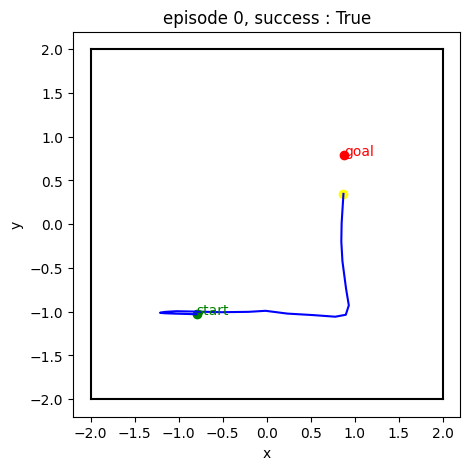

episode done at 0


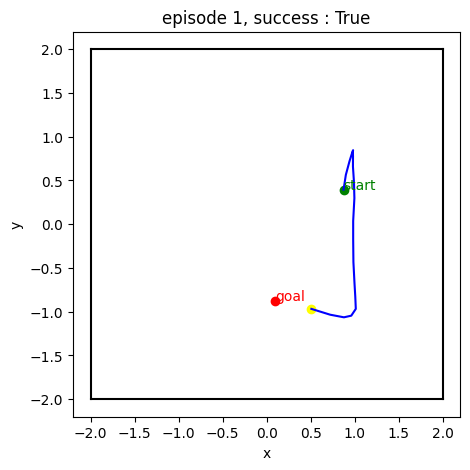

episode done at 1


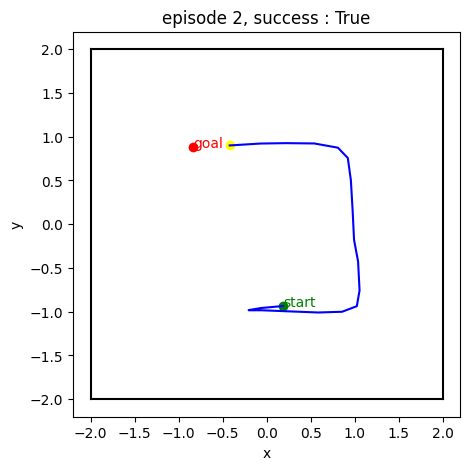

episode done at 2


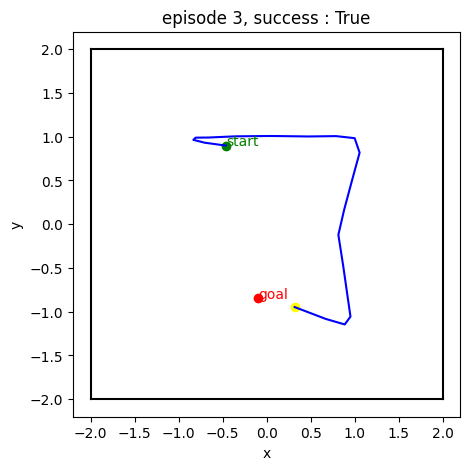

episode done at 3


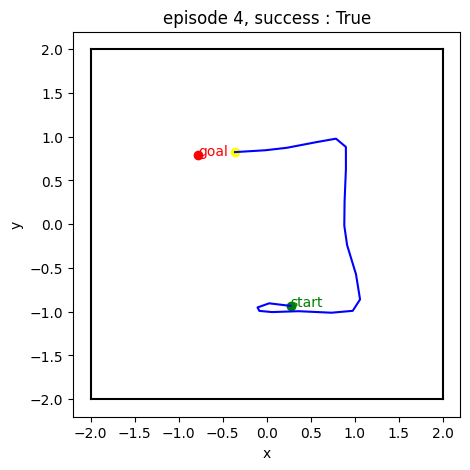

episode done at 4


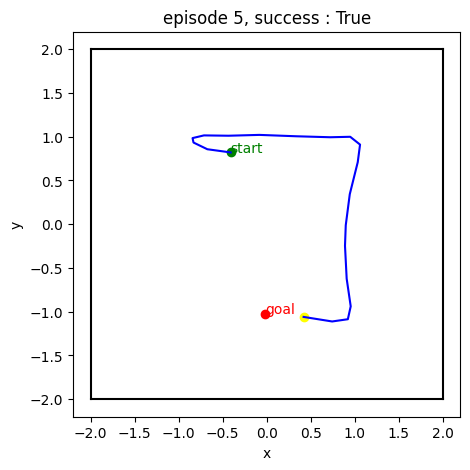

episode done at 5


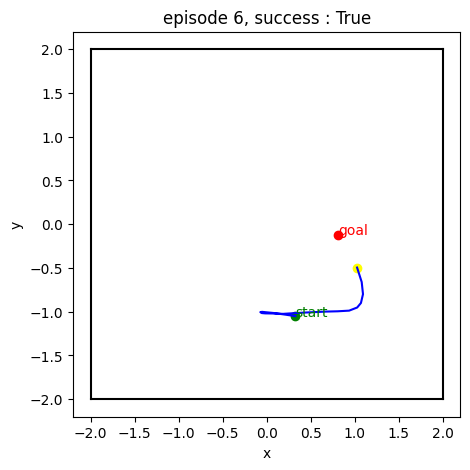

episode done at 6


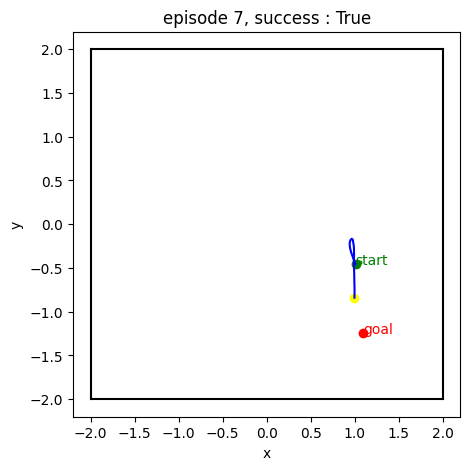

episode done at 7


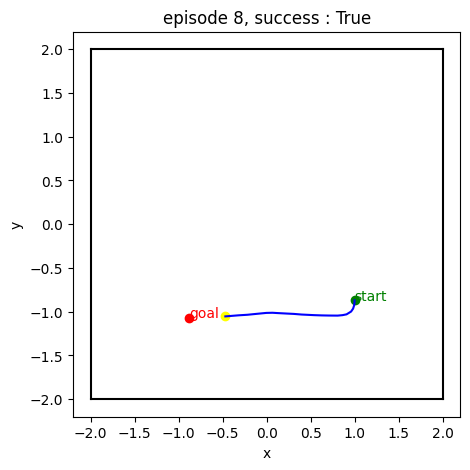

episode done at 8


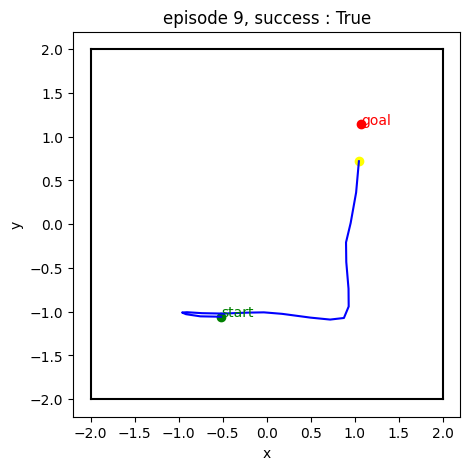

episode done at 9


In [ ]:
# plot map with matplotlib
import matplotlib.pyplot as plt

map_size = ((-2,2),(-2,2)) # x, y


def init_figure() :
    # draw outline 
    plt.figure(figsize=(5,5))
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][0], map_size[1][0]], color='black')
    plt.plot([map_size[0][0], map_size[0][1]], [map_size[1][1], map_size[1][1]], color='black')
    plt.plot([map_size[0][0], map_size[0][0]], [map_size[1][0], map_size[1][1]], color='black')
    plt.plot([map_size[0][1], map_size[0][1]], [map_size[1][0], map_size[1][1]], color='black')
    # set figure size


def plot_trajectory(trajectory, color='blue'):
    # plot trajectory
    plt.plot(trajectory[:,0], trajectory[:,1], color=color)

start_i = 0
n_epi = 10
episode_frames = []
episode_agent_states = []
episode_goals = []
episode_start = start_i
episode_done = False

print(len(data))
for i in range (start_i, start_i + n_epi) :
    achieved_goal = data[i]['observations'][:,:2]
    desired_goals = data[i]['observations'][:,-2:]

    # draw trajectory
    init_figure()
    plot_trajectory(np.array(achieved_goal))
    # draw goals
    plt.scatter(desired_goals[-1][0], desired_goals[-1][1], color='red')
    # draw start
    plt.scatter(achieved_goal[0][0], achieved_goal[0][1], color='green')
    # draw end
    plt.scatter(achieved_goal[-1][0], achieved_goal[-1][1], color='yellow')
    # add labels that show what meaning of green, yellow, red
    plt.text(achieved_goal[0][0], achieved_goal[0][1], 'start', color='green')
    #plt.text(episode_agent_states[-1][0], episode_agent_states[-1][1], 'end', color='yellow')
    plt.text(desired_goals[-1][0], desired_goals[-1][1], 'goal', color='red')
    
    plt.title(f'episode {i}, success : {data[i]["rewards"].any()}')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()
    episode_agent_states = []
    episode_goals = []
    episode_done = False
    print('episode done at', i)


In [ ]:
data[0]['observations'].shape

TypeError: list indices must be integers or slices, not str